In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

print(f'current device: {device}')

current device: mps


In [3]:
from sklearn.preprocessing import MinMaxScaler

class CpuDataset(Dataset):
    def __init__(self, path: str, time_steps: int, data_type:str='train'):
        """
        Cpu Dataset
            :param path: str
            :param time_steps: int
            :param data_type: str = 'train' | 'valid' | 'test'
        """
        
        self.scaler = MinMaxScaler((0, 1))
        
        data = pd.read_csv(path)
        data['timestamp'] = pd.to_datetime(data['timestamp'])
        data = data.set_index('timestamp')
        
        self.scaler.fit(data.iloc[: round(len(data) * 0.8 * 0.8)])
        data = pd.DataFrame(self.scaler.transform(data), columns=data.columns)
        
        data = (
            data.iloc[: round(len(data) * 0.8 * 0.8)] if data_type == 'train' else
            data.iloc[round(len(data) * 0.8 * 0.8): round(len(data) * 0.8)] if data_type == 'valid' else
            data.iloc[round(len(data) * 0.8):]
        )
        
        self.x, self.y = [], []
        for index in range(len(data) - time_steps):
            self.x.append(torch.FloatTensor(data.iloc[index: index + time_steps].to_numpy()).to(device))
            self.y.append(torch.FloatTensor(data.iloc[index + time_steps].to_numpy()).to(device))

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index: int):
        return self.x[index], self.y[index]

In [4]:
path = './data.csv'
time_steps = 12
batch_size = 16

In [5]:
train_dataset = CpuDataset(path=path, time_steps=time_steps, data_type='train')
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = CpuDataset(path=path, time_steps=time_steps, data_type='valid')
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CpuDataset(path=path, time_steps=time_steps, data_type='test')
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

print(f'train dataset size: {len(train_dataset)}')
print(f'valid dataset size: {len(valid_dataset)}')
print(f'test  dataset size: {len(test_dataset)}')

train dataset size: 5518
valid dataset size: 1370
test  dataset size: 1716


In [6]:
class Model(nn.Module):
    def __init__(self, num_layers:int, device: torch.device):
        super().__init__()

        self.num_layers = num_layers
        self.device = device
        self.h, self.c = None, None

        self.lstm = nn.LSTM(
            3,
            256,
            num_layers=self.num_layers,
            dropout=0.2,
            batch_first=True
        )
        self.dense = nn.Sequential(
            nn.Linear(256, 128),
            nn.Linear(128, 3)
        )

    def init_states(self, batch_size: int):
        self.h = self.c = torch.zeros(self.num_layers, batch_size, 256).to(self.device)

    def forward(self, X):
        out, (self.h, self.c) = self.lstm(X, (self.h, self.c))
        return self.dense(out[:, -1, :])

In [7]:
model = Model(num_layers=2, device=device).to(device)
model

Model(
  (lstm): LSTM(3, 256, num_layers=2, batch_first=True, dropout=0.2)
  (dense): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [8]:
criterion = nn.MSELoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=1e-3
)

In [9]:
best_loss = 10 ** 10
patience_limit = 3
patience_count = 0

for epoch in range(10):
    train_loss, validation_loss = 0.0, 0.0
    
    model.train()
    for batch_idx, (X, y) in enumerate(train_loader):
        optimizer.zero_grad()

        model.init_states(batch_size=X.shape[0])

        loss = criterion(model(X), y)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
    train_loss /= len(train_loader)

    model.eval()
    with torch.no_grad():
        for X, y in valid_loader:
            model.init_states(batch_size=X.shape[0])

            loss = criterion(model(X), y)
            validation_loss += loss.item()

        validation_loss /= len(valid_loader)

    if validation_loss > best_loss:
        patience_count += 1
        if patience_count > patience_limit:
            print("=== Early Stopping ===")
            break
    else:
        best_loss = validation_loss

    print(f"epoch: {epoch + 1:>2}/10 | train loss: {train_loss:.5f} | validation loss: {validation_loss:.5f}")

epoch:  1/10 | train loss: 0.00206 | validation loss: 0.00094
epoch:  2/10 | train loss: 0.00082 | validation loss: 0.00073
epoch:  3/10 | train loss: 0.00067 | validation loss: 0.00086
epoch:  4/10 | train loss: 0.00064 | validation loss: 0.00083
epoch:  5/10 | train loss: 0.00066 | validation loss: 0.00079
epoch:  6/10 | train loss: 0.00061 | validation loss: 0.00064
=== Early Stopping ===


In [10]:
def MAPE(label, predict):
    absolute_percentage_error = torch.abs((label - predict) / label)
    return torch.mean(absolute_percentage_error[torch.isfinite(absolute_percentage_error)])

In [11]:
def evaluate_model(model: nn.Module, dataloader: DataLoader):
    model.eval()
    
    predict, label, mapes = [], [], []
    with torch.no_grad():
        for (x, y) in dataloader:
            model.init_states(batch_size=x.shape[0])

            out = model(x)
            mapes.append(MAPE(y, out))

            predict.append(out.cpu().numpy())
            label.append(y.cpu().numpy())
            
    return (
        pd.DataFrame(np.concatenate(predict), columns=['min','max','average']),
        pd.DataFrame(np.concatenate(label), columns=['min','max','average']),
        mapes
    )

predictions, labels, mape = evaluate_model(model, test_loader)
print(f"MAPE min : {min(mape)} | max : {max(mape)} | avg : {sum(mape) / len(mape)}")

MAPE min : 0.048524271696805954 | max : 0.171381875872612 | avg : 0.07170745730400085


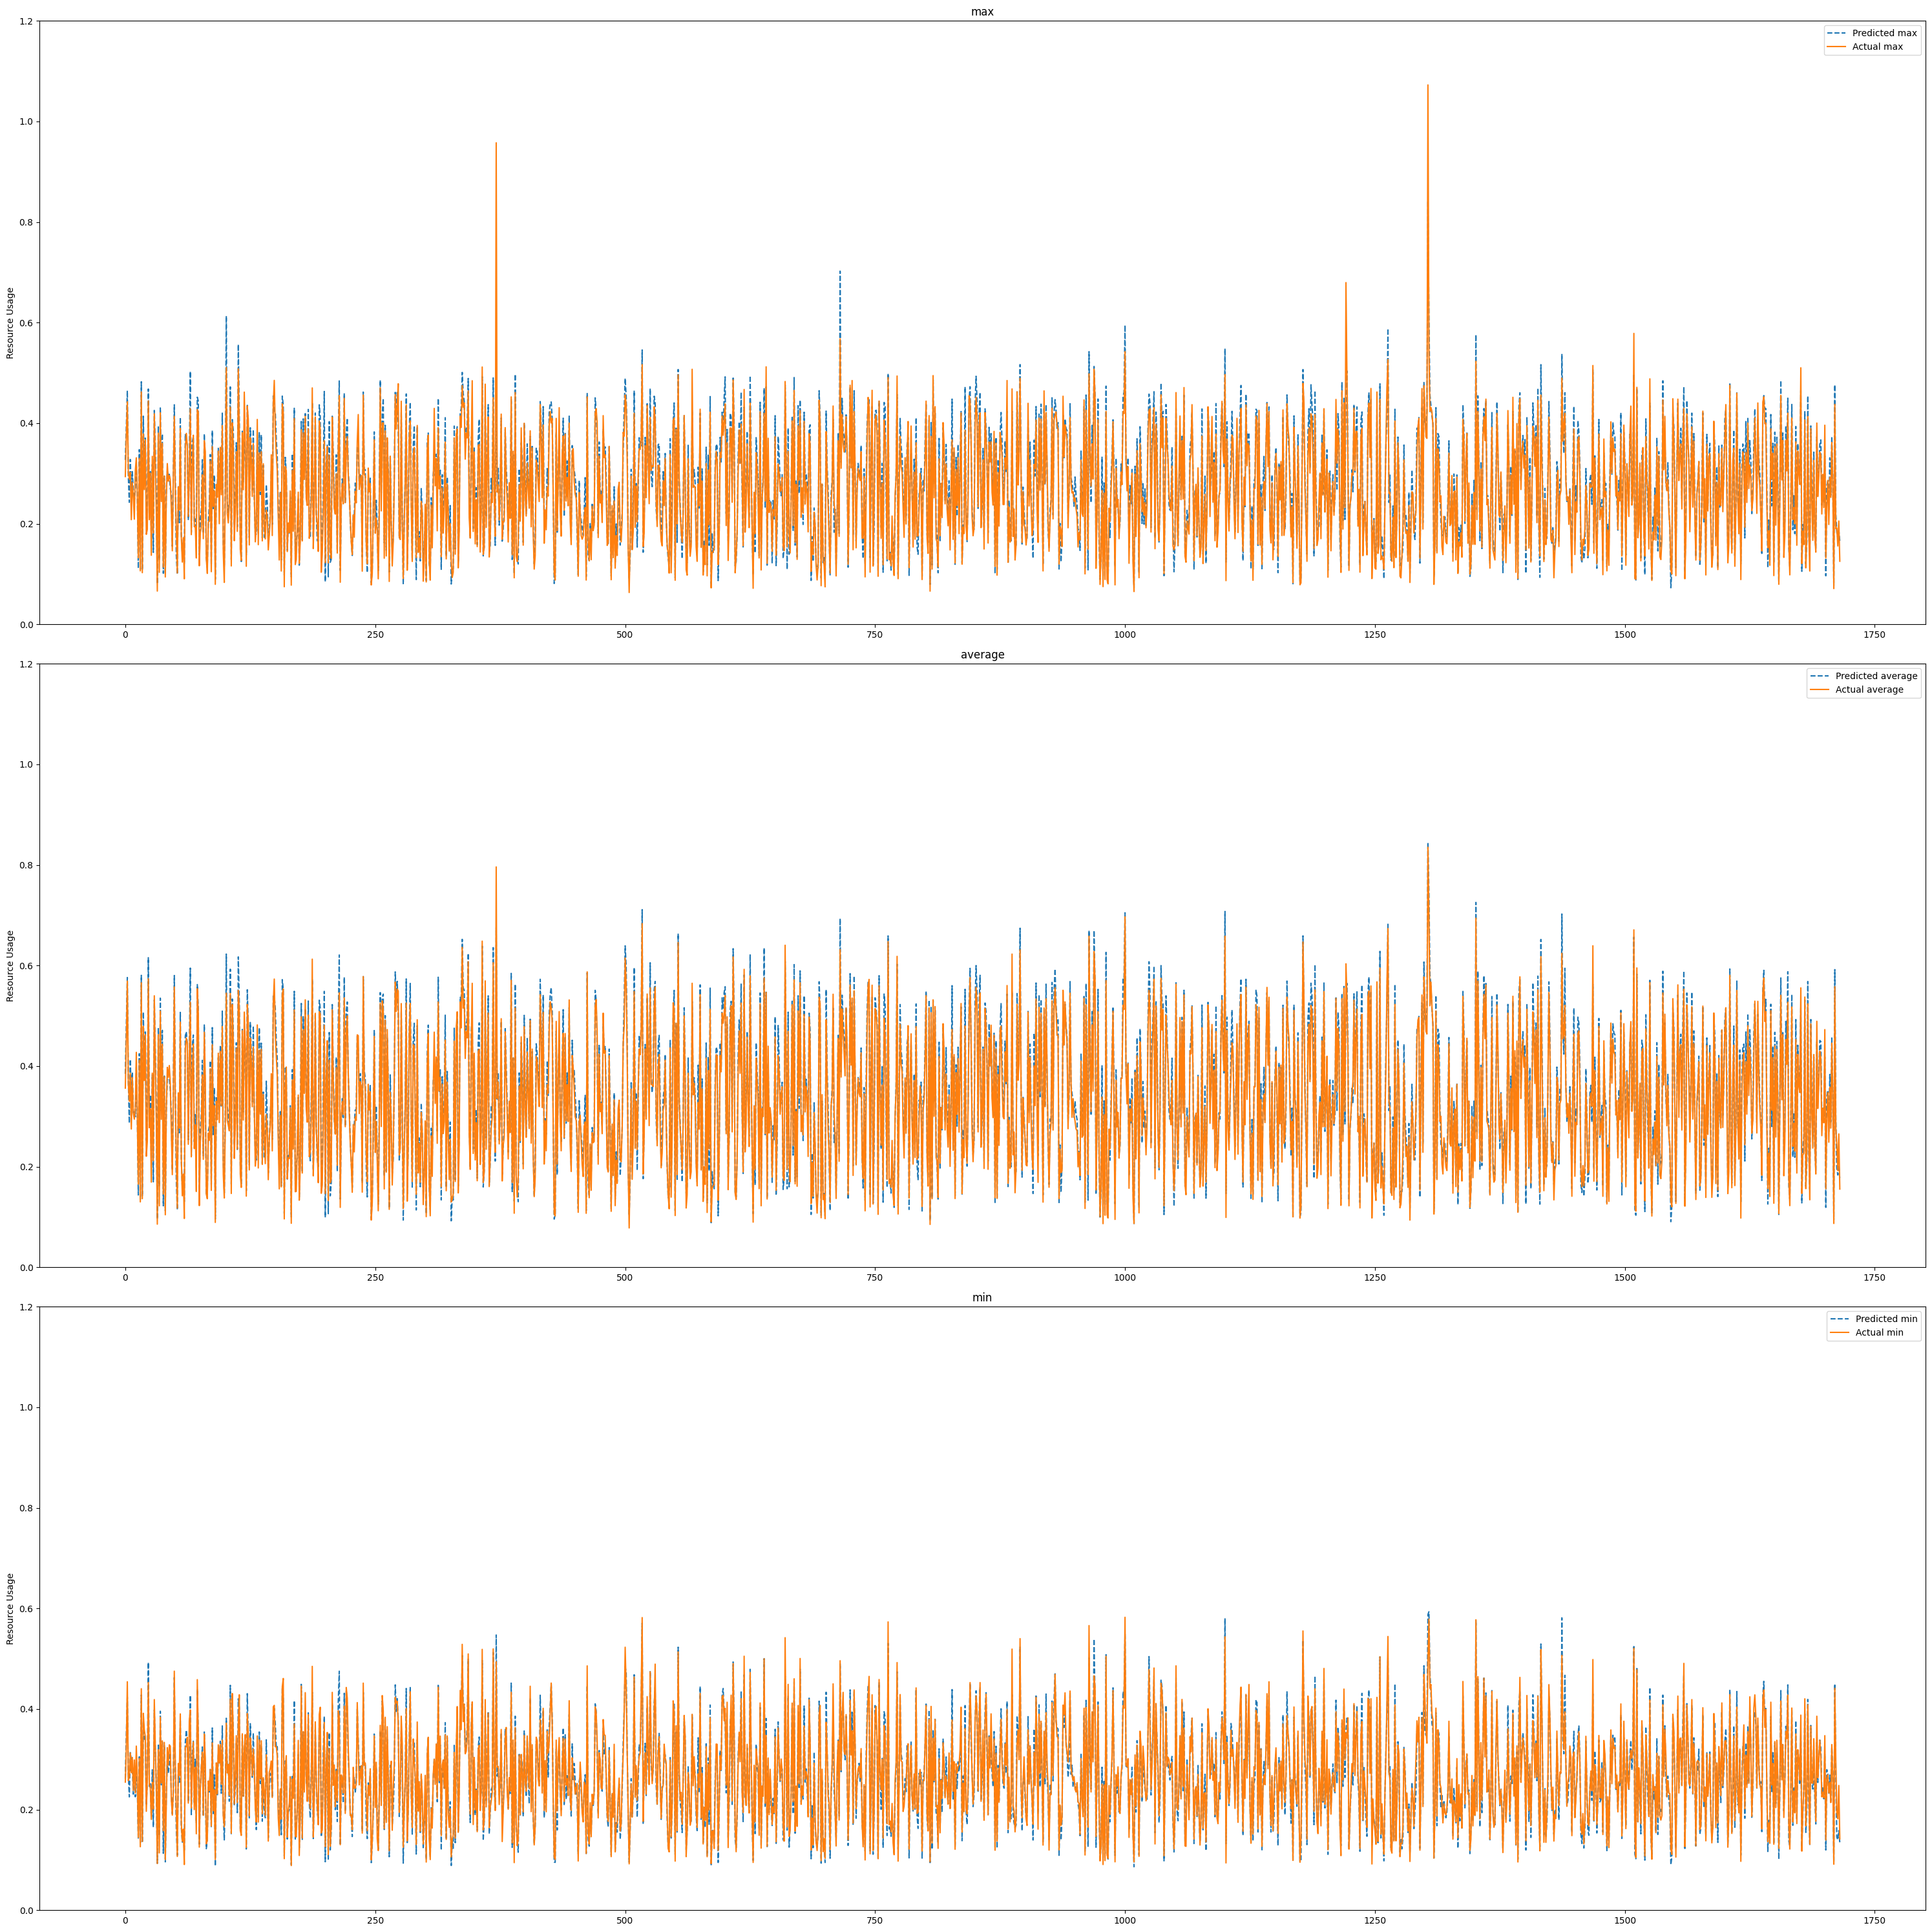

In [12]:
def plot_graphs(predict: np.ndarray, label: np.ndarray, column: str, index: int):
    plt.subplot(3, 1, index)
    plt.plot(predict[column], label=f'Predicted {column}', linestyle='dashed')
    plt.plot(label[column], label=f'Actual {column}')
    plt.yticks(np.arange(0, 1.4, 0.2))
    plt.title(f'{column}')
    plt.ylabel('Resource Usage')
    plt.legend()

plt.figure(figsize=(30, 30))

plot_graphs(predictions, labels, 'max', index=1)
plot_graphs(predictions, labels, 'average', index=2)
plot_graphs(predictions, labels, 'min', index=3)

plt.tight_layout()